<a href="https://colab.research.google.com/github/AntonAIG/gridwide_analytics/blob/main/PJME_load_profile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hourly Power Consumption Profile of PJM

The hourly power consumption profile data of a transmission service operator (TSO) measured in megawatts (MW) was provided for use in data analysis tasks.

### Table of Contents
* Introduction
* Business Questions
* Data Source and Description
* Summary Statistics
* Data Analysis
* Visualization
* Conclusion and Recommendations

### Introduction

The JPM Interconnection LLC (JPM) is a TSO based in USA, and operating as part of the Eastern Interconnection grid. Their network coverage includes Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The data that was provided were historical data of power consumption for the Eastern Region herein refered to as JPME, from 2002 to 2018.

### Business Questions
The JPME dataset provides the means of evaluating the consumption partterns and seasonality trends in this region.

We want to:
> Find trends in energy consumption around hours of the day, holidays, or long term trends.

> Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.

### Data Source and Description
The JPME hourly load data was originaly provided by JPM. The open source version can be found in the [Kaggel](https://www.kaggle.com/robikscube/hourly-energy-consumption?select=PJME_hourly.csv) dataset provided by Rob Mulla.

It contains hourly load data from Jan. 2002 to Aug. 2018 - a time series data with a single parameter (JPME_MW). Since the data is well referenced, and can be traced back to the original publisher, I can say that the data is authentic.

One important point to note is that there is no seperation or idenfitication of the various types of consumption: industrial, commercial, and residential. This means that the observations can't be tailored down to specific load types or classes, and therefore cannot be used to infere specific consumer behaviors.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import holidays
import matplotlib.pyplot as plt

%matplotlib inline

sns.set_theme(style='whitegrid', palette='Set1')

#### Loading Data
The data was loaded from a local directory

In [2]:
PATH = "/content/drive/MyDrive/Project Portfolio/PJME_hourly.csv"
load = pd.read_csv(PATH, parse_dates=["Datetime"])
load.sort_values("Datetime", ascending=True, inplace=True)
load.head()

,Datetime,PJME_MW
8734,2002-01-01 01:00:00,30393.0
8735,2002-01-01 02:00:00,29265.0
8736,2002-01-01 03:00:00,28357.0
8737,2002-01-01 04:00:00,27899.0
8738,2002-01-01 05:00:00,28057.0


In [3]:
load.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145366 entries, 8734 to 140254
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  145366 non-null  datetime64[ns]
 1   PJME_MW   145366 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3 MB


There are 145k datapoints reperesenting almost 17 years of hourly readings. There are no columns that defines the contribution of each state to the total load consumption. Thus, we can only see the data as the summation of all measurements in this region.

### Summary Statistics

In this section, we want to find out the basic statistical properties of the data.

In [4]:
load.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


The average power consumption in the entire timeframe is 32000MW. The minimum value shows that there are no 0 entries that can be considered as outliers.

### Data Analysis

Here we are going to perform a series of evaluations to make the data more useable. I will process/clean the data, introduce new features, and group the data by some factors.

**Checking for Null**

In [5]:
load.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

There are no *null* values in the dataset.


---



I am going to introduce new features: time of day in hours (hour), day of week (dayofweek), month of year (month), years (year), holidays (holiday), and seasons (season)

In [6]:
def date_time_features(dataframe, date_column):
  date_list = dataframe[date_column]

  dataframe['hour'] = np.int8(date_list.dt.hour)
  dataframe['hourofweek'] = np.int16(((date_list.dt.dayofweek) * 24 + 24) - (24 - date_list.dt.hour) + 1)
  dataframe['dayofweek'] = np.int8(date_list.dt.dayofweek)
  dataframe['month'] = np.int8(date_list.dt.month)
  dataframe['year'] = np.int16(date_list.dt.year)

  # extracting holidays with the 'holiday' package
  us_holidays = []
  years = list(range(2002, 2019, 1))

  for year in years:
    for date in holidays.UnitedStates(years=year).items():
      us_holidays.append(str(date[0]))
  
  #make a list of all the holidays in a given year
  holiday = []
  for item in range(len(date_list)):
    date = date_list.iloc[item]
    date_item = date.strftime('%Y-%m-%d')
    if date_item in us_holidays:
      holiday.append(int(1))
    else:
      holiday.append(int(0))
    item+=1
  
  #make a 'holiday' column in the dataframe
  dataframe['holiday'] = holiday

  # search for seasons in the given months of the datetime object
  seasons = []
  for month in date_list.dt.month:
    if month in range(3,6):
      seasons.append('spring')
    elif month in range(6,9):
      seasons.append('summer')
    elif month in range(9,11):
      seasons.append('autumn')
    else:
      seasons.append('winter')

  #make a 'seasons' column in the dataframe
  dataframe['season'] = seasons

  return dataframe

In [7]:
load = date_time_features(load, 'Datetime')
load.head()

,Datetime,PJME_MW,hour,hourofweek,dayofweek,month,year,holiday,season
8734,2002-01-01 01:00:00,30393.0,1,26,1,1,2002,1,winter
8735,2002-01-01 02:00:00,29265.0,2,27,1,1,2002,1,winter
8736,2002-01-01 03:00:00,28357.0,3,28,1,1,2002,1,winter
8737,2002-01-01 04:00:00,27899.0,4,29,1,1,2002,1,winter
8738,2002-01-01 05:00:00,28057.0,5,30,1,1,2002,1,winter


Let us further create the following dataframes:
1. Total annual power consumption: `annual_load`
2. Average monthly consumption: `monthly_load`
3. Average weekly consumption: `weekly_load`
4. Weekday table: `weekdays`
5. Weekends and holidays table: `weekends_holidays`

In [8]:
annual_load = load.groupby('year', as_index=False).sum().drop(['hour','dayofweek','month','holiday'], axis=1)
monthly_load = load.groupby('month', as_index=False).mean().drop(['hour','dayofweek','year','holiday'], axis=1)
weekly_load = load.groupby('hourofweek', as_index=False).mean().drop(['hour','dayofweek','month','year','holiday'], axis=1)
weekdays = load[load['dayofweek']<5][load['holiday']==0]
weekends = load[load['dayofweek']>4]
holidays = load[load['holiday']==1]
holidays.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


4391

### Visualization

There are various types of trends and properties that can be seen in the data. However, we will focus our attention on the ones that will help us answer the business questions.


---
**Trends**



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Power Consumption')

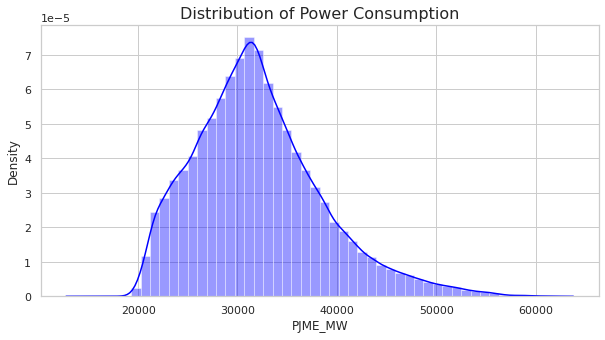

In [10]:
# distribution plot for power consumption
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(load['PJME_MW'], color='blue', ax=ax)
ax.set_title('Distribution of Power Consumption', fontsize=16)

The histogram distribution above shows that the dataset is nomarly distributed, with a mean value around 32000MW. Very few days have power consumption above 50000MW.

In [11]:
# line plot function
def line_plots(dataframe, x='', y='', hue=None):
  fig, ax = plt.subplots(figsize=(16,8))
  sns.lineplot(x=x, y=y, data=dataframe, hue=hue, ax=ax)
  plt.title('Line plot of {} against {} according to {}'.format(x, y, hue), fontsize=16)
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

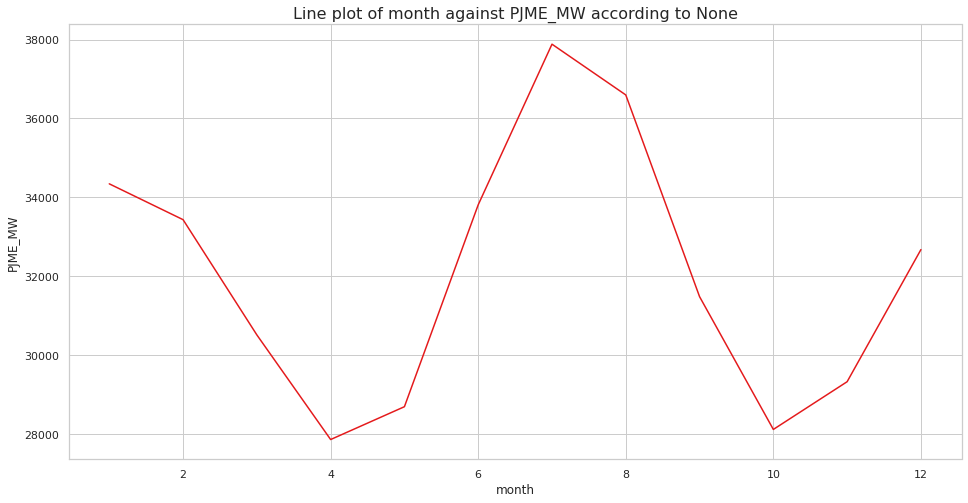

In [12]:
line_plots(monthly_load, x='month', y='PJME_MW')

The plot above shows the average monthly trend of power consumption in this network region. It shows that the summer periods have significantly higer consumption with July as the highest. The lowest consumptions are in the transitional seasons from winter to summer (April) and from summer to winter (October). Neither heating nor cooling in required in these months.

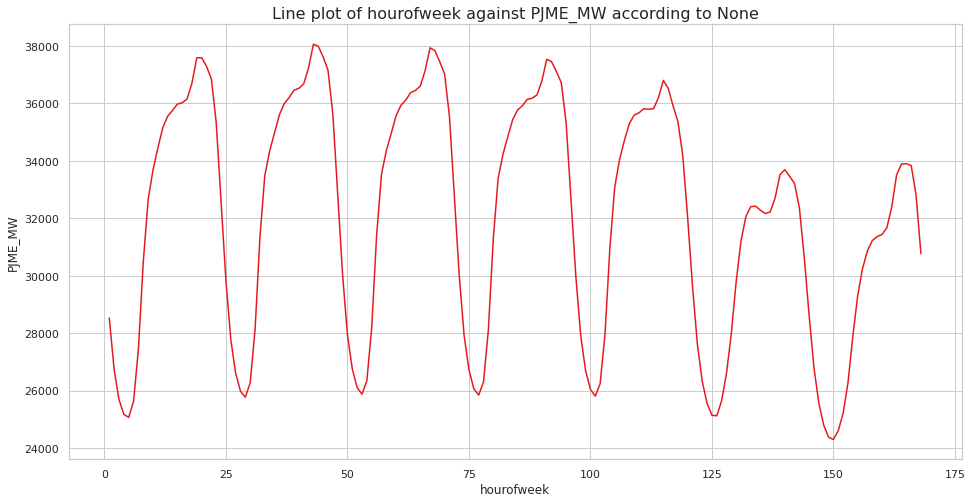

In [13]:
line_plots(weekly_load, x='hourofweek', y='PJME_MW')

The line plot above shows the seasonality in the timeseries data for average weekly power consumptions. The morning hours have significantly lower amount of consumption than the evening hours. It follows a repetitive partern althrough the week.

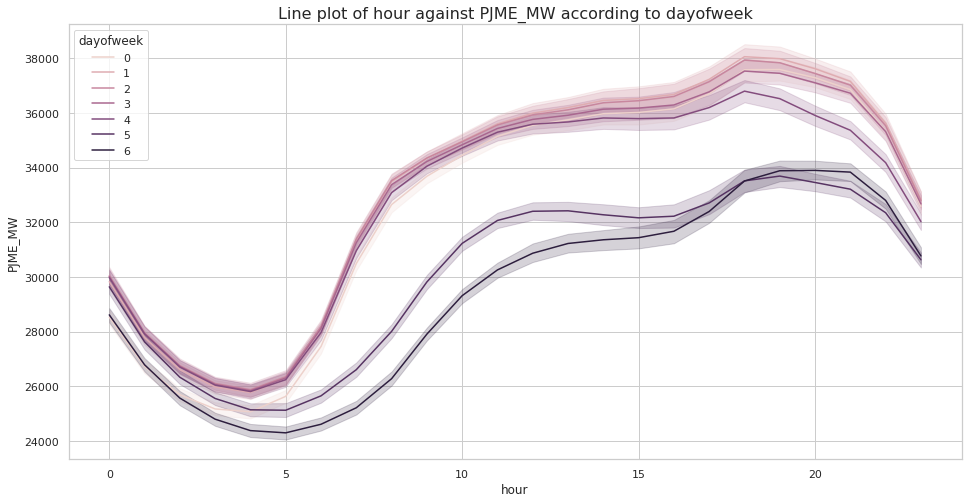

In [14]:
line_plots(load, x='hour', y='PJME_MW', hue='dayofweek')

The line plot above shows the diference between the weekday and weekend consumption of power. The weekday period is significantly higher than the weekends.

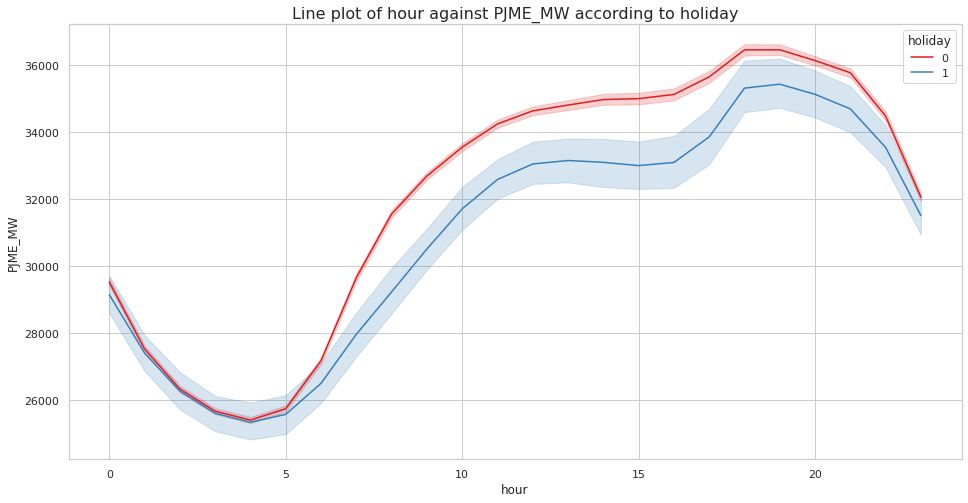

In [17]:
line_plots(load, x='hour', y='PJME_MW', hue='holiday')

Just like the weekday-weekend plot, the holiday and non-holiday line plot above shows that load consumption during the holiday is simmilar to the weekends. The trend line of holiday consumption is lower than that of the non-holidy periods.


---

**Yearly Trends**

Text(0.5, 1.0, 'Annual Trend in Total Power Consumption')

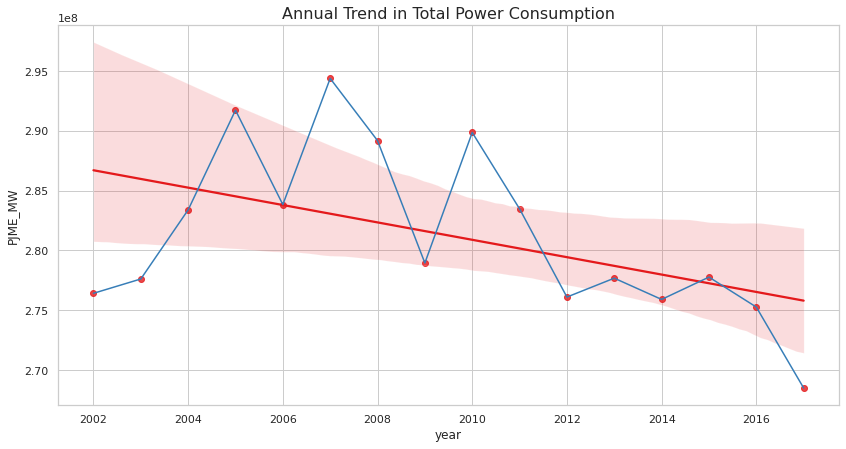

In [9]:
# annual trend in total power consumption
fig, ax = plt.subplots(figsize=(14,7))
sns.regplot(x='year', y='PJME_MW', data=annual_load[:16], ax=ax)
sns.lineplot(x='year', y='PJME_MW', data=annual_load[:16], ax=ax)
ax.set_title('Annual Trend in Total Power Consumption', fontsize=16)

The plot above shows the annual trend of load consumption from 2002 to 2017. 2018 was excluded from the data because it is incomplete. A downward trend signifies the reduction in power consumption. This is as a result of new energy efficient appliances and loads that replaces the older ones. 2017 is the lowest recorded total annual consumption.

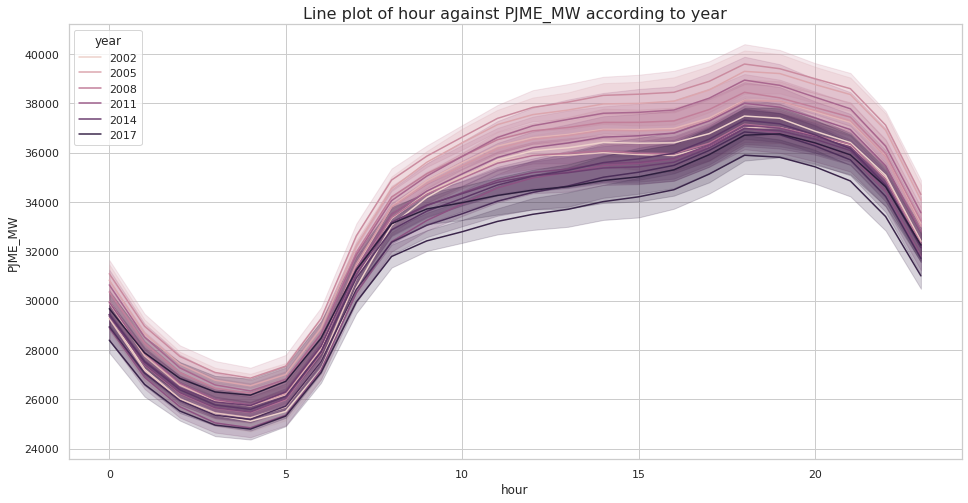

In [15]:
line_plots(weekdays, x='hour', y='PJME_MW', hue='year')

The chart above was used to showcase the daily consumption profile for each year on the weekdays. A simmilar chart for the weekends can be seen below. As the year goes by, the *total daily consumption* (area under the curve) reduces. This trend is simmilar to the year-on-year total power consumption line chart.

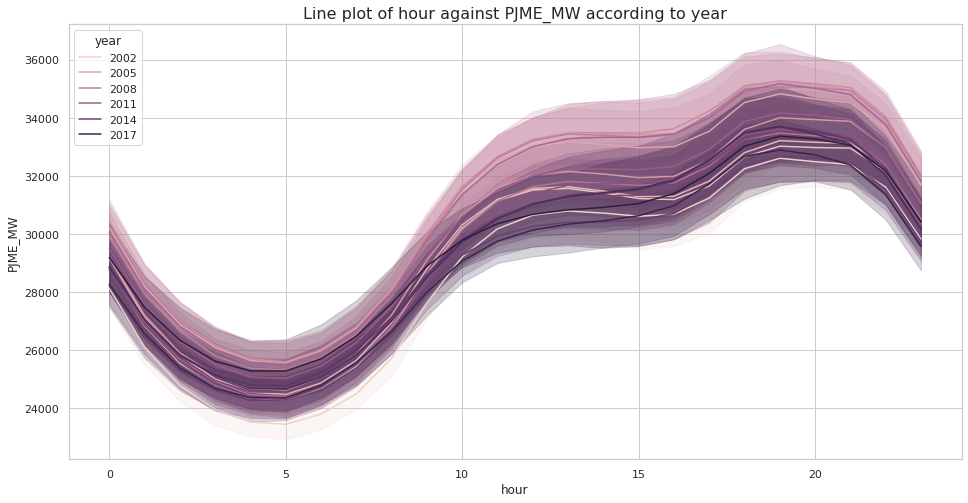

In [16]:
line_plots(weekends, x='hour', y='PJME_MW', hue='year')

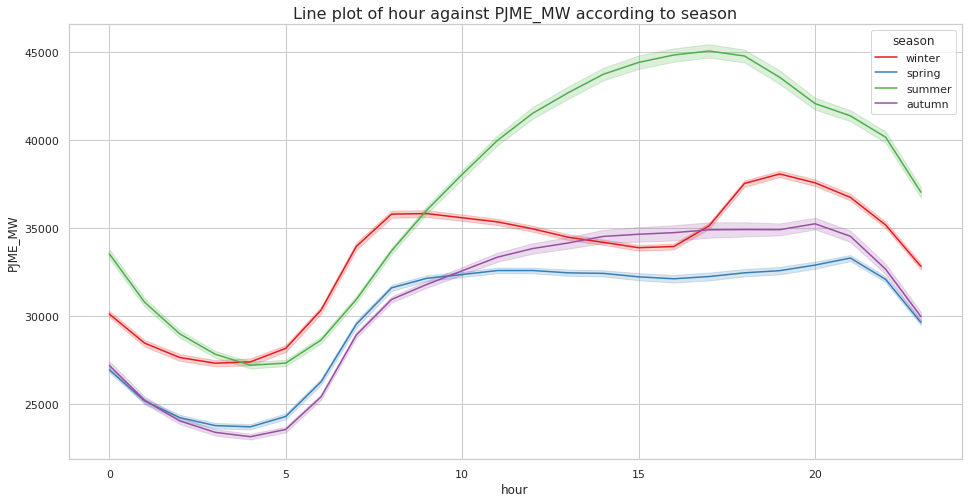

In [18]:
line_plots(weekdays, x='hour', y='PJME_MW', hue='season')

The seasonal changes in daily trends of load consumption as shown in the figure above indicates that there is a significant difference in the consumption parterns for each season.

The transition seasons (autumn and spring) have similar profiles while the summer month has the peak consumption. The midnigh and morning hours have similar curves accross the seasons. The winter and summer months by the time of the day have higher hourly consumptions.

### Conclusion and Recommendation

The insights produced from the visualizations above can be summarized as follows:
1. There is a significant reduction in the year-to-year power demand consumption. The exact reason for this should be investigated further but it is known that new residential and commercial devices are becoming more energy efficient. Thus, new appliances tend to consume less power.
2. The hourly trends for the weekdays are considerably higher than weekends and holidays. This is because the industrial and commerical consumers does not operate in the weekends. I recommend that the total power consumption profile should be broken down into residential, commercial, and industrial consumption classess. This will aid in understanding the inherent behaviour of each class. However, the trend shows that peak consumption occures withing the normal operating hours of most businesses: 07:00 - 18:00.
3. Power consumption during the winter and summer months (especially the summer months) is significantly hihger than the spring and autumn months. This is because a substantial amount of cooling and heating is required to maintain the room temperature. Space heating and cooling is required in all consumer classes during the winter an summer seasons. Heating and cooling equipment consume more than 50% of power in residential and commerical classes.

In summary, I recommend that additional energy savings measures be adopted to reduce peak demand for the winter and summer months. Such measures might be to improve building insulation by retrofiting. See my previous work on [Evaluation of Energy Savings by Building Retrofiting from the ASHRAE Energy Evaluation Project](https://github.com/AntonAIG/energy_efficient_buildings/blob/main/ASHRAE_energy_eff/ashrae_building_eff.ipynb). Another energy savings optimization measure that can be implemented in the PJME is Conservation Voltage Reduction. This technology is used to detect and reduce peak power consumption. See my previous work on [Conservation Voltage Reduction](https://github.com/AntonAIG/cvr_data_analytics)